# Exploring different numerical schemes

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import diags

a  = 1.0
nx = 200
T  = 1.0
x  = np.linspace(0,1,nx,endpoint=False)
def exact(a,T,x):
    return np.exp(-(((x - a*T)%1 - 0.25)/0.05)**2)
    
t_ex = np.linspace(0,T,500)
u_ex = exact(a,T,t_ex)
CFLs = [0.6, 1.0, 1.2]


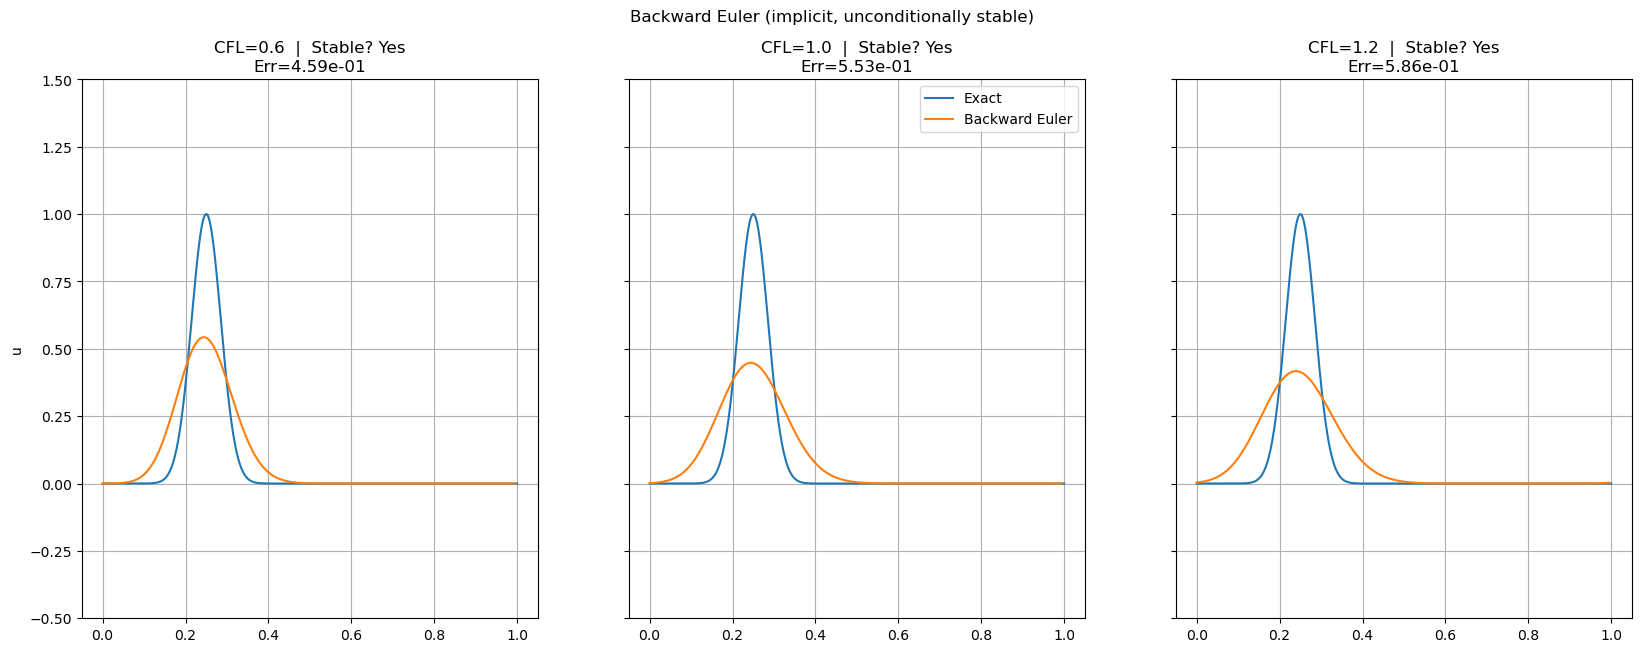

In [97]:
def backward_euler(a, x, cfl, T):
    nx = x.size
    dx = 1/nx
    dt = cfl*dx/abs(a)
    nt = int(T/dt)

    ν = a*dt/(2*dx)
    N = nx
    A = diags(
        [
            -ν*np.ones(N),
             np.ones(N),
             +ν*np.ones(N)
        ],
        offsets=[-1, 0, +1],
        shape=(N, N),
        format='lil'
    )
    A[0, -1] = -ν
    A[-1, 0] = +ν

    A = A.tocsc()
    u = np.exp(-((x-0.25)/0.05)**2)

    for _ in range(nt):
        u = np.linalg.solve(A.toarray(), u)

    return u

fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
for ax, cfl in zip(axes, CFLs):
    u_num = backward_euler(a, x, cfl, T)
    err = np.max(np.abs(u_num - exact(a, T, x)))

    ax.plot(t_ex, u_ex, '-', label='Exact')
    ax.plot(x,    u_num, '-', label='Backward Euler')
    ax.set_title(f'CFL={cfl:.1f}  |  Stable? Yes\nErr={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right')
plt.ylim(-0.5, 1.5)
plt.suptitle('Backward Euler (implicit, unconditionally stable)')
plt.show()


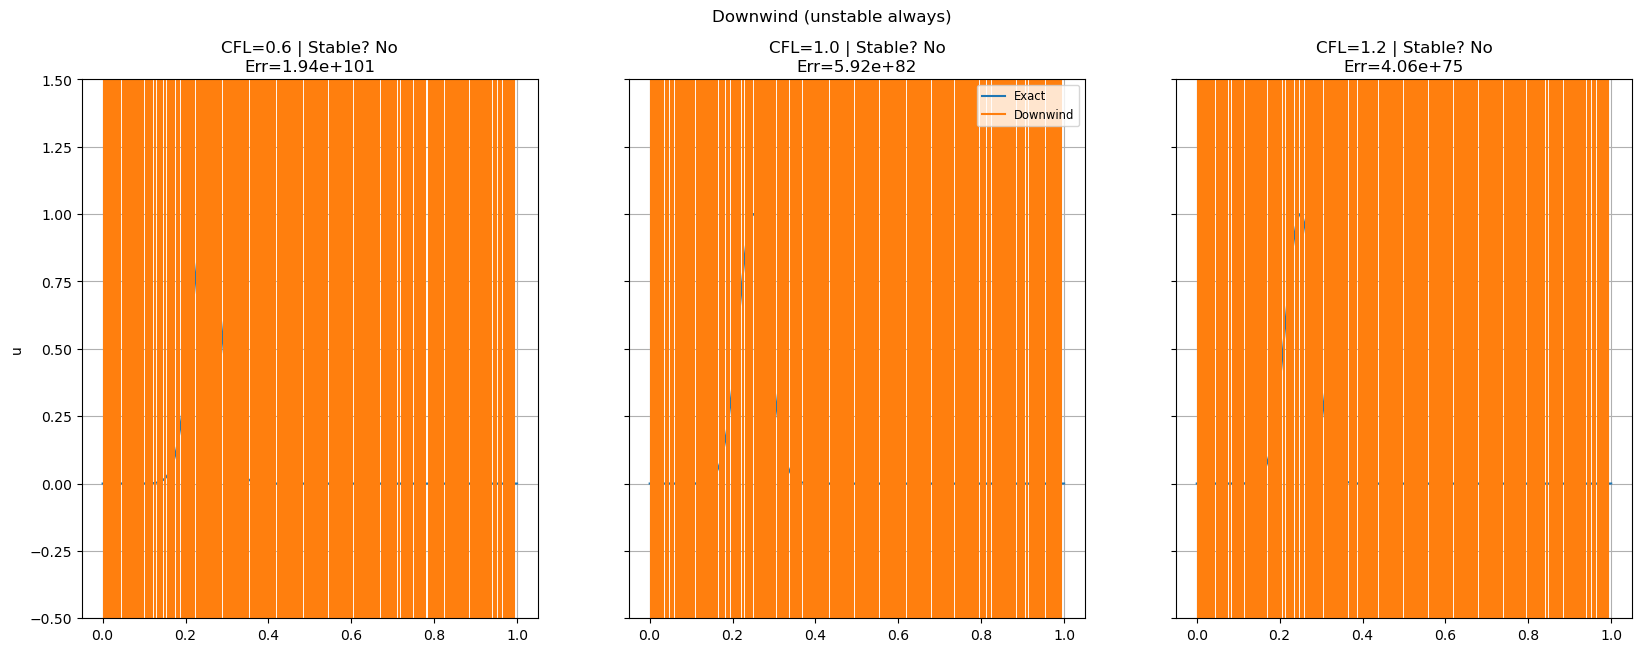

In [98]:
def downwind(a,nx,cfl,T):
    dx=1/nx; dt=cfl*dx/abs(a); nt=int(T/dt)
    u = np.exp(-((x-0.25)/0.05)**2)
    for _ in range(nt):
        un = u.copy(); ν=a*dt/dx
        if a>0:
            u = un - ν*(np.roll(un,-1) - un)
        else:
            u = un - ν*(un - np.roll(un,1))
    return u

fig,axes = plt.subplots(1,3,figsize=(20,7),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=downwind(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    ax.plot(t_ex,u_ex,'-',label='Exact')
    ax.plot(x,u,'-',label='Downwind')
    ax.set_title(f'CFL={cfl:.1f} | Stable? No\nErr={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.ylim(-0.5, 1.5)
plt.suptitle('Downwind (unstable always)')
plt.show()


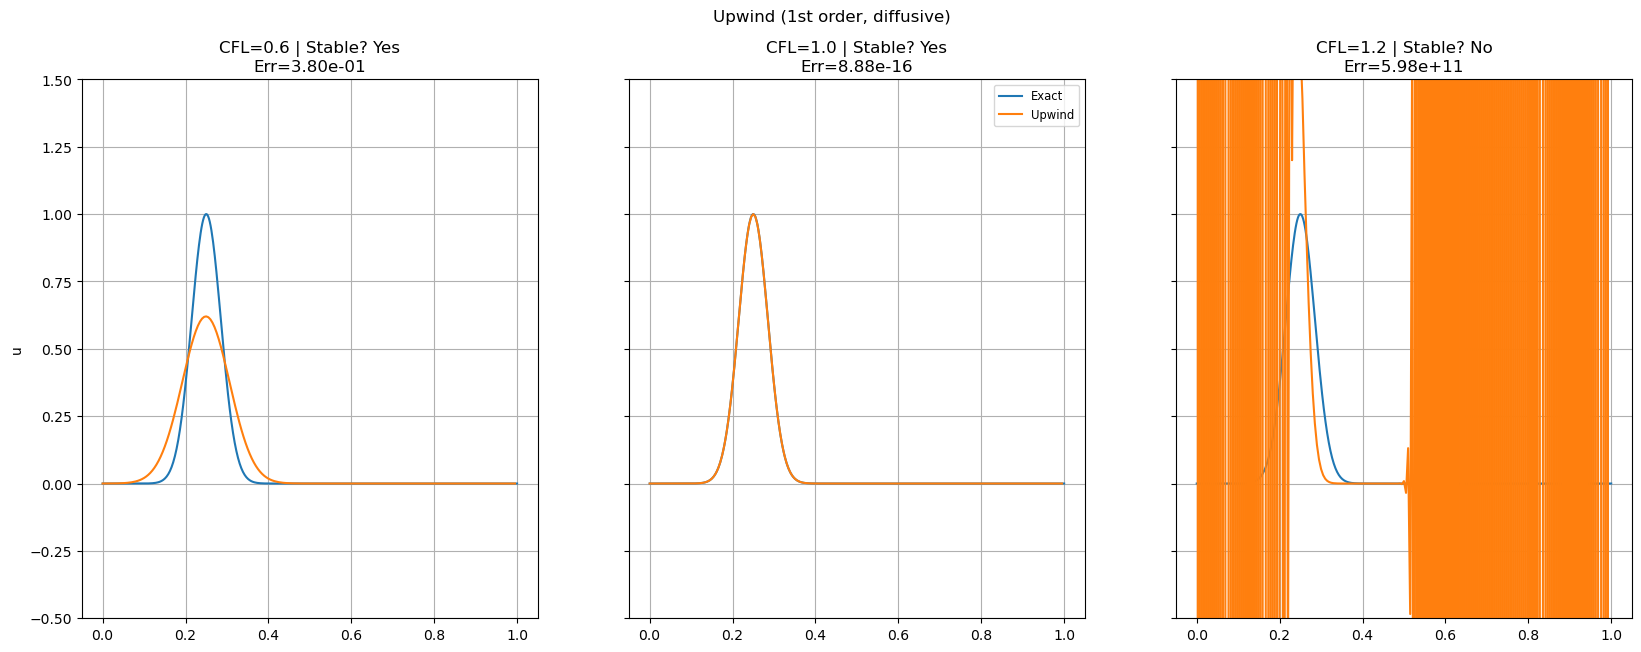

In [99]:
def upwind(a,nx,cfl,T):
    dx=1/nx; dt=cfl*dx/abs(a); nt=int(T/dt)
    u = np.exp(-((x-0.25)/0.05)**2)
    for _ in range(nt):
        un = u.copy(); ν=a*dt/dx
        if a>0:
            u = un - ν*(un - np.roll(un,1))
        else:
            u = un - ν*(np.roll(un,-1) - un)
    return u

fig,axes = plt.subplots(1,3,figsize=(20,7),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=upwind(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    ax.plot(t_ex,u_ex,'-',label='Exact')
    ax.plot(x,u,'-',label='Upwind')
    ax.set_title(f'CFL={cfl:.1f} | Stable? {"Yes" if cfl<=1 else "No"}\nErr={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.ylim(-0.5, 1.5)
plt.suptitle('Upwind (1st order, diffusive)')
plt.show()


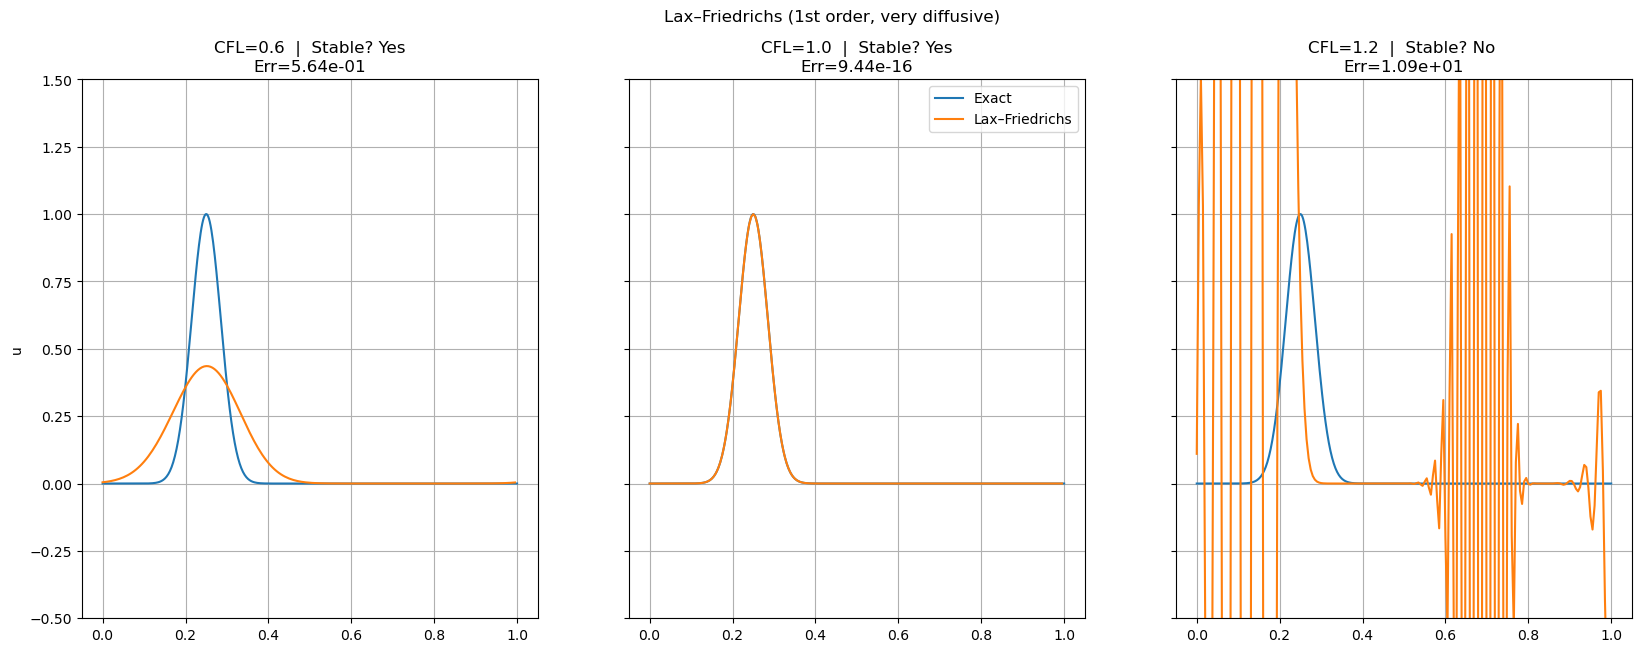

In [104]:
def lax_friedrichs(a, nx, cfl, T):
    dx = 1/nx
    dt = cfl*dx/abs(a)
    nt = int(T/dt)
    ν  = a*dt/dx

    u = np.exp(-((x - 0.25)/0.05)**2)

    for _ in range(nt):
        ul, ur = np.roll(u,1), np.roll(u,-1)
        u = 0.5*(ul + ur) - 0.5*ν*(ur - ul)

    return u

fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
for ax, cfl in zip(axes, CFLs):
    u_num = lax_friedrichs(a, nx, cfl, T)
    err   = np.max(np.abs(u_num - exact(a, T, x)))

    ax.plot(t_ex, u_ex, '-', label='Exact')
    ax.plot(x,     u_num, '-', label='Lax–Friedrichs')
    ax.set_title(f'CFL={cfl:.1f}  |  Stable? {"Yes" if cfl<=1 else "No "}\nErr={err:.2e}')
    ax.grid()

axes[0].set_ylabel('u')
axes[1].legend(loc='upper right')
plt.ylim(-0.5, 1.5)
plt.suptitle('Lax–Friedrichs (1st order, very diffusive)')
plt.show()


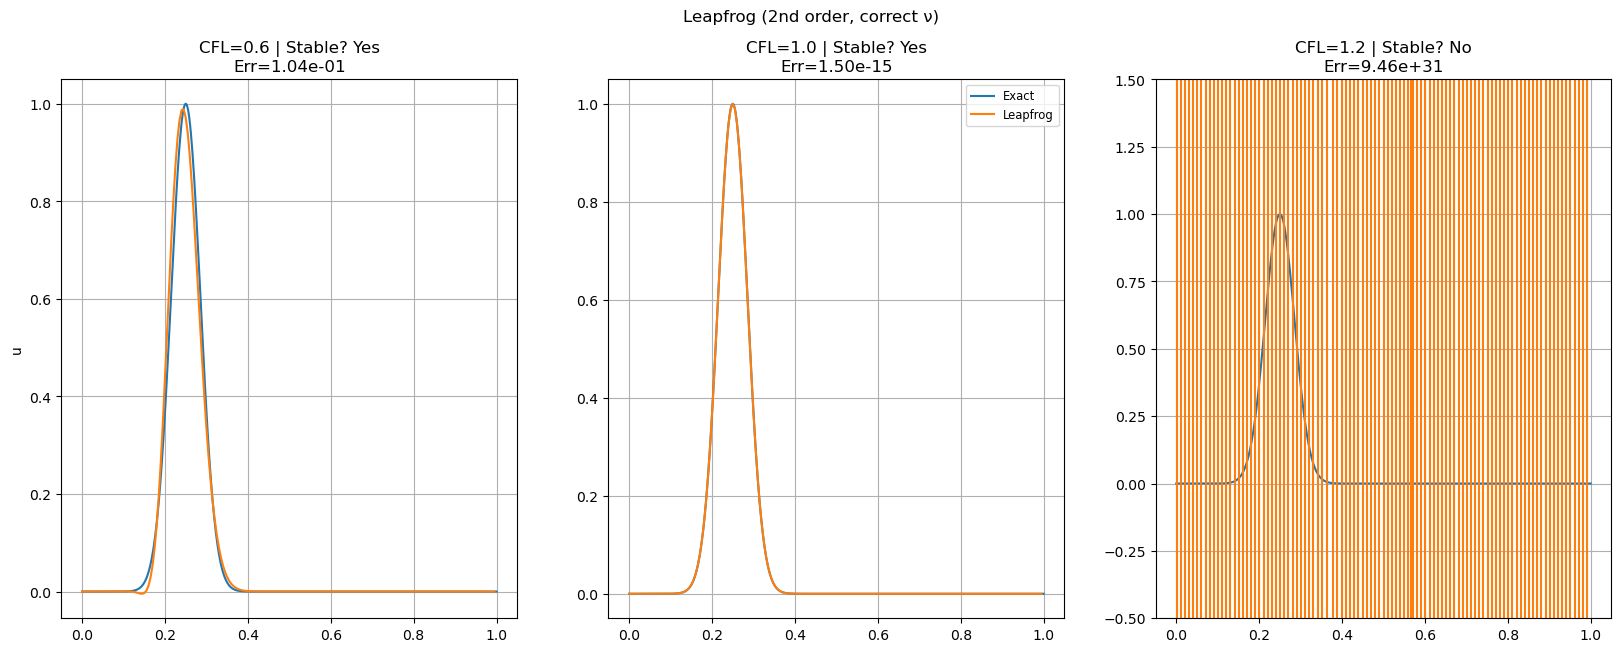

In [105]:
def leapfrog(a, nx, cfl, T):
    dx = 1/nx
    dt = cfl*dx/abs(a)
    nt = int(T/dt)
    ν  = a*dt/dx

    u_nm1 = np.exp(-((x-0.25)/0.05)**2)

    ul, ur = np.roll(u_nm1,1), np.roll(u_nm1,-1)
    u_n = u_nm1 \
          - 0.5*ν*(ur - ul) \
          + 0.5*(ν**2)*(ur - 2*u_nm1 + ul)

    for _ in range(1, nt):
        u_np1 = u_nm1 - ν*( np.roll(u_n,-1) - np.roll(u_n,1) )
        u_nm1, u_n = u_n, u_np1

    return u_n

fig, axes = plt.subplots(1,3,figsize=(20,7), sharey=False)
for ax, cfl in zip(axes, CFLs):
    u_num = leapfrog(a, nx, cfl, T)
    err   = np.max(np.abs(u_num - exact(a,T,x)))
    ax.plot(t_ex, u_ex, '-', label='Exact')
    ax.plot(x,     u_num,'-',label='Leapfrog')
    ax.set_title(f'CFL={cfl:.1f} | Stable? {"Yes" if cfl<=1 else "No"}\nErr={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.ylim(-0.5, 1.5)
plt.suptitle('Leapfrog (2nd order, correct ν)')
plt.show()


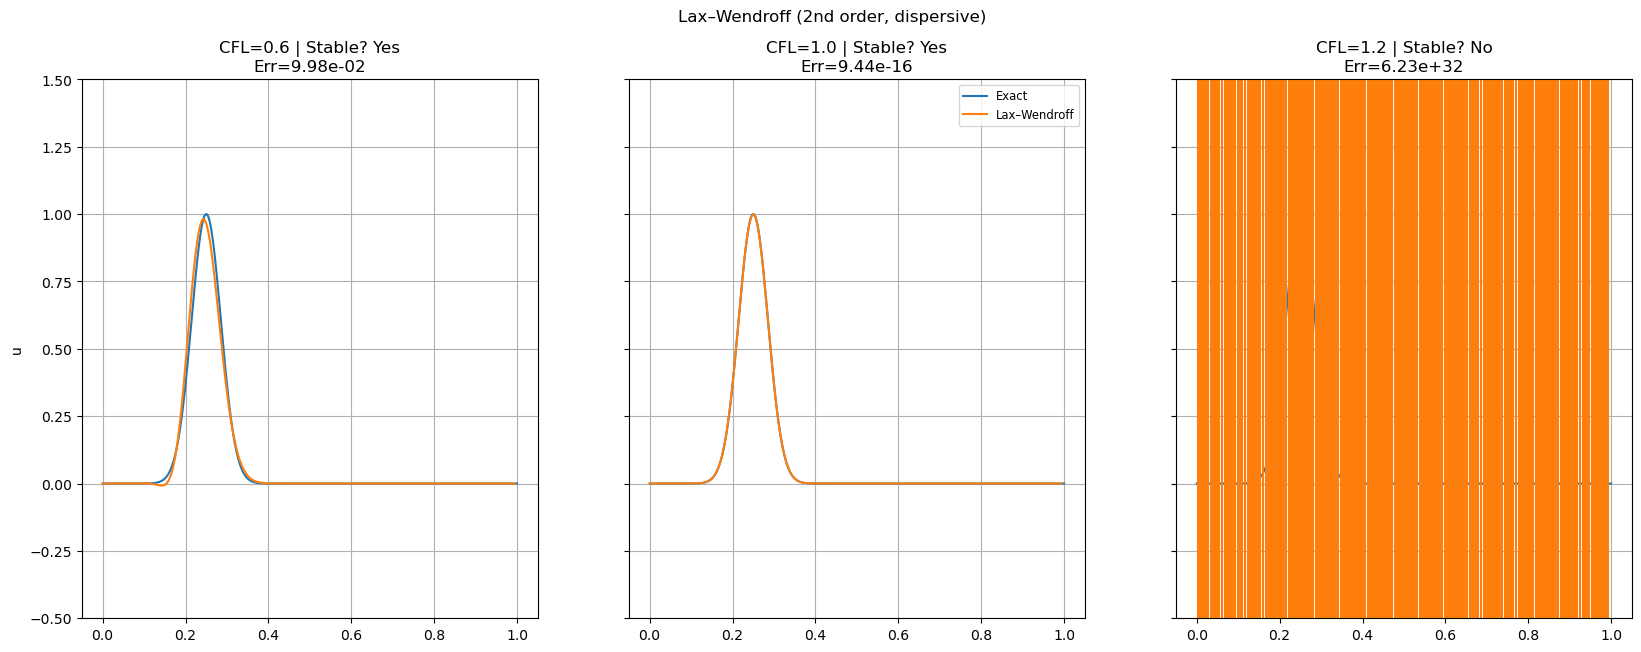

In [102]:
def lax_wendroff(a,nx,cfl,T):
    dx=1/nx; dt=cfl*dx/abs(a); nt=int(T/dt)
    u = np.exp(-((x-0.25)/0.05)**2)
    ν = a*dt/dx
    for _ in range(nt):
        ul,ur = np.roll(u,1), np.roll(u,-1)
        u = u - 0.5*ν*(ur-ul) + 0.5*ν*ν*(ur - 2*u + ul)
    return u

fig,axes = plt.subplots(1,3,figsize=(20,7),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=lax_wendroff(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    ax.plot(t_ex,u_ex,'-',label='Exact')
    ax.plot(x,u,'-',label='Lax–Wendroff')
    ax.set_title(f'CFL={cfl:.1f} | Stable? {"Yes" if cfl<=1 else "No"}\nErr={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.ylim(-0.5, 1.5)
plt.suptitle('Lax–Wendroff (2nd order, dispersive)')
plt.show()

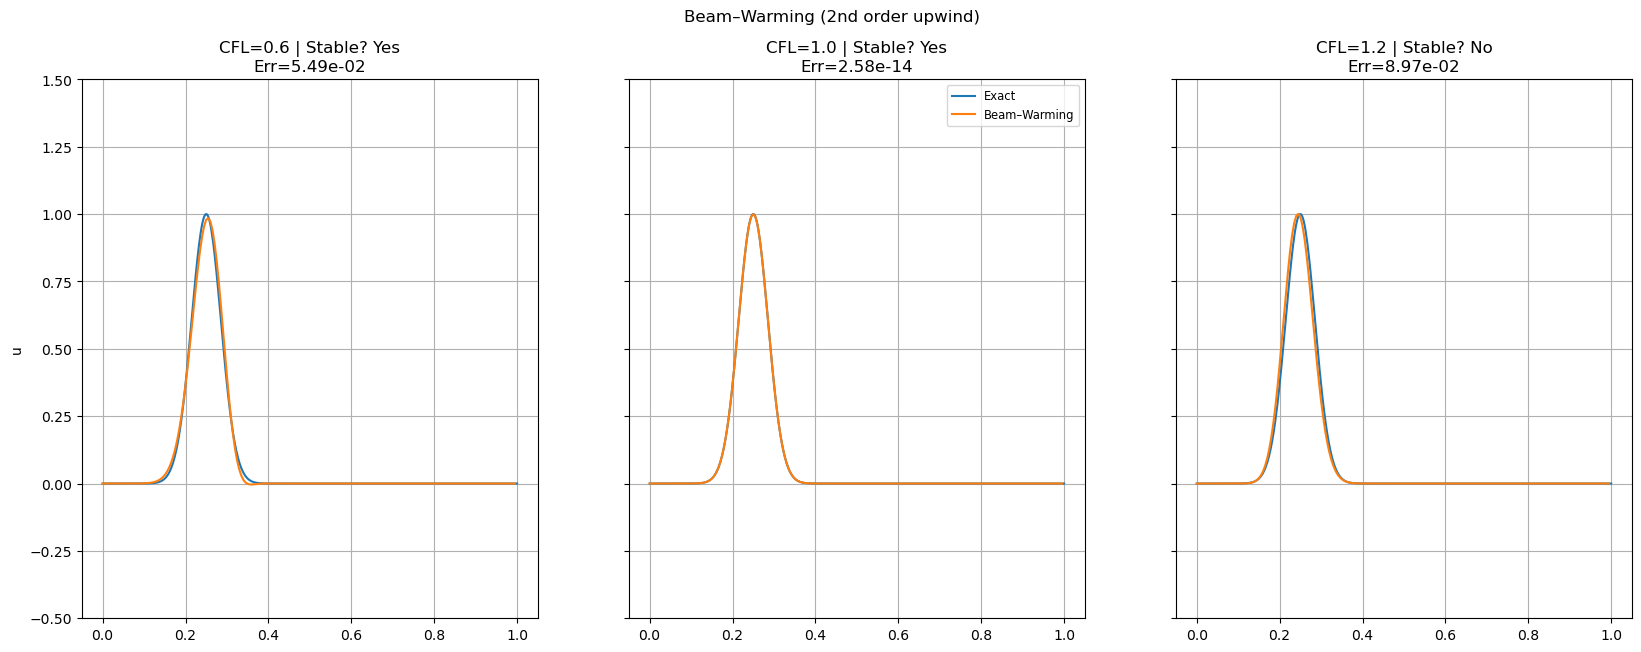

In [103]:
def beam_warming(a,nx,cfl,T):
    dx=1/nx; dt=cfl*dx/abs(a); nt=int(T/dt)
    u_prev = np.exp(-((x-0.25)/0.05)**2)
    ν = a*dt/dx
    u = u_prev - ν*(u_prev - np.roll(u_prev,1))
    for _ in range(1,nt):
        ul1, ul2, ul3 = u, np.roll(u,1), np.roll(u,2)
        u_new = (u 
                 - 0.5*ν*(3*u - 4*ul2 + ul3)
                 + 0.5*ν*ν*(u - 2*ul2 + ul3))
        u_prev, u = u, u_new
    return u

fig,axes = plt.subplots(1,3,figsize=(20,7),sharey=True)
for ax,cfl in zip(axes,CFLs):
    t0=time.perf_counter(); u=beam_warming(a,nx,cfl,T); cpu=time.perf_counter()-t0
    err=np.max(np.abs(u-exact(a,T,x)))
    ax.plot(t_ex,u_ex,'-',label='Exact')
    ax.plot(x,u,'-',label='Beam–Warming')
    ax.set_title(f'CFL={cfl:.1f} | Stable? {"Yes" if cfl<=1 else "No"}\nErr={err:.2e}')
    ax.grid()
axes[0].set_ylabel('u')
axes[1].legend(loc='upper right',fontsize='small')
plt.ylim(-0.5, 1.5)
plt.suptitle('Beam–Warming (2nd order upwind)')
plt.show()
